In [9]:
import pandas as pd 
import numpy as np
import os 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import scipy.stats as sp_stats

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [133]:
bar_figures_dir = "figures/analyte_bar"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
HWDC_bar_palette={"A":"#FEACA7","B":"#D4D4D4"}
HWDC_point_palette={"A":"#FF2804","B":"#000000"}

def sig_str_from_p(pval):
    if pval < 0.001:
        return "***"
    elif pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    else:
        return ""
    
def tissue_analyte_long_df(data_df,analytes,tissues,sampleID_col,A_group_re=r'AF|AM'):
    """Generate long form DataFrame with Measurement (numerical) and Analyte and Tissue (categorical) columns
    """
    long_df = pd.DataFrame(columns=["Measurement","Analyte","Tissue"])
    for tissue in tissues: 
        for analyte in analytes: 
            #Partition input dataframe
            if "Tissue" in data_df.columns: 
                tissue_data = data_df.loc[data_df["Tissue"]==tissue] #important for multiple analytes/tissues case
            else:
                tissue_data = data_df #single analyte case (usually)
            A_data = tissue_data.loc[tissue_data[sampleID_col].str.contains(A_group_re),analyte]
            B_data = tissue_data.loc[~tissue_data[sampleID_col].str.contains(A_group_re),analyte]
            
            tissue_short_df = pd.DataFrame(index=tissue_data.index,columns=long_df.columns)
            #Populate long form data for seaborn 
            tissue_short_df.loc[A_data.index,"Measurement"] = A_data 
            tissue_short_df.loc[A_data.index,"Group"] = ["A"]*len(A_data.index)
            tissue_short_df.loc[A_data.index,"Tissue"] = [tissue]*len(A_data.index)
            tissue_short_df.loc[A_data.index,"Analyte"] = [analyte]*len(A_data.index)
            tissue_short_df.loc[B_data.index,"Measurement"] = B_data 
            tissue_short_df.loc[B_data.index,"Group"] = ["B"]*len(B_data.index)
            tissue_short_df.loc[B_data.index,"Tissue"] = [tissue]*len(B_data.index)
            tissue_short_df.loc[B_data.index,"Analyte"] = [analyte]*len(B_data.index)
            
            long_df = pd.concat([long_df,tissue_short_df],ignore_index=True)
    long_df.dropna(how="all",inplace=True)        
    return long_df

def single_analyte_stats(data_df,analyte_col,tissue,sampleID_col,A_group_re=r'AF|AM',stats_test="Mann-Whitney"):
    if "Tissue" in data_df.columns:
        data_df = data_df.loc[data_df["Tissue"]==tissue] #subset to tissue if tissue in data_df columns, otherwise ignore  
    else:
        pass 
    
    A_data = data_df.loc[data_df[sampleID_col].str.contains(A_group_re),analyte_col]
    B_data = data_df.loc[~data_df[sampleID_col].str.contains(A_group_re),analyte_col] 
    if stats_test == "Mann-Whitney":
        stat, pval = sp_stats.mannwhitneyu(x=A_data,y=B_data,alternative="two-sided")
    sig_str = sig_str_from_p(pval)
    return stat, pval, sig_str 

def multiple_analyte_stats(data_df,analytes,tissues,sampleID_col,A_group_re=r'AF|AM',stats_test="Mann-Whitney"):
    stats_columns = ["Analyte","Tissue","stat","pval","sig_str"]
    stats_df = pd.DataFrame(columns=stats_columns)
    i = 0 
    for analyte in analytes:
        for tissue in tissues: 
            stat,pval,sig_str = single_analyte_stats(data_df,analyte,tissue,sampleID_col,
                                                    A_group_re=A_group_re,stats_test=stats_test)
            row_srs = pd.Series(dict(zip(stats_columns,[analyte,tissue,stat,pval,sig_str])))
#             display(row_srs)
            stats_df.loc[i,:] = row_srs
            i+=1 
    return stats_df
def significance_bracket(ax,pval,sig_str,sigstr_fmt="std",x1=0,x2=0,y1=0,y2=0):
    #Determining coordinates for brackets and sig_str
    if x1 == 0 and x2 == 0: #Default to first two xticks (ie single analyte situation) if x1/x2 not provided
        xticks = ax.get_xticks()
        x1, x2 = xticks[0], xticks[1]
    if y1 == 0 and y2 == 0:
        ymin, ymax = ax.get_ylim()
        ydiff = ymax-ymin
        y2 = ymax - (ydiff)*0
        y1 = y2-(ydiff)*.01
    #Plot significance bracket and sig_str; different cases for sigstr_fmt (ie ns/* format vs pval=...)
    if sigstr_fmt == "std":
        if sig_str == "":
            sig_str = "ns"
            plt.text((x1+x2)*.5, y2, sig_str, ha='center', va='bottom', color='k',weight="bold")
        elif "*" in sig_str:
            #Positioning for * format sig_str
            plt.text((x1+x2)*.5, y2, sig_str, ha='center', va='bottom', color='k',weight="bold")
        else: 
            plt.text((x1+x2)*.5, y2, sig_str, ha='center', va='bottom', color='k',weight="bold")
        plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    elif sigstr_fmt == "pval": #Annotation text is of form p=x.xxx
        pval_str = "p={:.3f}".format(pval)
        plt.text((x1+x2)*.5, y2+ydiff*0.01, pval_str, ha='center', va='bottom', color='k',weight="bold")
        plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    else: #Default behavior, don't add bracket/sigstr 
        pass
#Single metabolite barplot generation 
def single_analyte_barplot(data_df,analyte,tissue,A_group_re=r'AF|AM',sampleID_col="SampleID",
                           ax=None,units="µM",legend=True,stats_test="Mann-Whitney",sigstr_fmt="std"):
    tissue = tissue.title() #Title String capitalization bc we classy 
    #Partition input dataframe
    #stats test results 
    stat,pval,sig_str = single_analyte_stats(data_df,analyte,tissue,sampleID_col=sampleID_col,
                                              stats_test=stats_test)
    #Generate long form data for seaborn 
    tissue_analyte_df = tissue_analyte_long_df(data_df,[analyte],[tissue],sampleID_col=sampleID_col,
                                               A_group_re=A_group_re)
    if not ax:
        new_fig = True
        fig,ax = plt.subplots(1,1,figsize=(1,6))
    else: 
        new_fig = False

    #Overlay swarmplot over barplot of individual sample data 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        sns.barplot(data=tissue_analyte_df,x="Group",y="Measurement",ax=ax,zorder=0,palette=HWDC_bar_palette,
                    capsize=0.1,errwidth=1)

        sns.swarmplot(data=tissue_analyte_df,x="Group",y="Measurement", ax=ax, zorder=1,palette=HWDC_point_palette)
    #spaghetti code for changing error bar hues on seaborns barplot 
    face_colors = list(HWDC_bar_palette.values())
    point_colors = list(HWDC_point_palette.values())
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        newcolor = point_colors[i//lines_per_err]
        line.set_color(newcolor)
    #Matplotlib formatting 
    #Add units to ylabel
    ax.set_ylabel("{0} ({1})".format(analyte,units),fontsize=12,fontweight="bold")
    ax.set_xlabel(tissue,labelpad=10,fontsize=12,fontweight="bold")
    
    significance_bracket(ax,pval,sig_str,sigstr_fmt=sigstr_fmt)
    #bold xtick/yticks
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    ax.set_xticks([])#Remove xticks (will just show A/B group labels)
    
    if new_fig:
        #Add title, legend to new plot 
        title_str = "{0}\n{1}".format(analyte,tissue)
        ax.set_title(title_str,fontsize=14,fontweight="bold")
        if legend:
            A_patch = matplotlib.patches.Patch(color=face_colors[0], label='Prevotella')
            B_patch = matplotlib.patches.Patch(color=face_colors[1], label='No Prevotella')
            plt.legend(handles=[A_patch,B_patch])
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
        
        analyte_path_str = analyte.replace('/','.')
        figure_path = "{0}/{1}_{2}.png".format(bar_figures_dir,analyte_path_str,tissue)
        plt.savefig(figure_path,dpi=300,bbox_inches="tight",facecolor="w")
        
        
def multiple_analyte_barplot(data_df,analytes,tissues,A_group_re=r'AF|AM',sampleID_col="SampleID",
                           ax=None,units="µM",stats_test="Mann-Whitney",legend=False,sigstr_fmt="std"):
    if not ax:
        plot_width = (len(analytes)*len(tissues))
        fig,ax = plt.subplots(1,1,figsize=(plot_width,6))
    long_df = tissue_analyte_long_df(data_df,analytes,tissues,sampleID_col=sampleID_col,A_group_re=A_group_re)
    stats_df = multiple_analyte_stats(data_df,analytes,tissues,sampleID_col=sampleID_col,
                                       A_group_re=A_group_re,stats_test=stats_test)
    pvals, sig_strs = stats_df["pval"].tolist(),stats_df["sig_str"].tolist()
    #Overlay swarmplot over barplot of individual sample data 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if len(tissues) > 1: 
            sns.barplot(data=long_df,x="Tissue",y="Measurement",hue="Group",ax=ax,zorder=0,palette=HWDC_bar_palette,
                    capsize=0.1,errwidth=1)
            sns.swarmplot(data=long_df,x="Tissue",y="Measurement",hue="Group",ax=ax, zorder=1,
                          palette=HWDC_point_palette,dodge=True)
            ax.set_xlabel("Tissue",labelpad=5,fontsize=16,weight="bold")
            ax.set_ylabel("{0} ({1})".format(analytes[0],units),fontsize=16,weight="bold")
        else: 
            sns.barplot(data=long_df,x="Analyte",y="Measurement",hue="Group",ax=ax,zorder=0,palette=HWDC_bar_palette,
                    capsize=0.1,errwidth=1)
            sns.swarmplot(data=long_df,x="Analyte",y="Measurement",hue="Group",ax=ax, zorder=1,
                          palette=HWDC_point_palette,dodge=True)
            if units == "nM":
                ax.set_ylabel("Acylcarnitine levels ({0})".format(units),fontsize=16,weight="bold")
            elif units == "µM":
                ax.set_ylabel("Amine levels ({0})".format(units),fontsize=16,weight="bold")
            ax.set_xlabel(tissues[0],labelpad=0,fontsize=16,weight="bold")

    #spaghetti code for changing error bar hues on seaborns barplot 
    face_colors = list(HWDC_bar_palette.values())
    point_colors = list(HWDC_point_palette.values())
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        color_index = i//(lines_per_err*len(tissues)*len(analytes))
        newcolor = point_colors[color_index]
        line.set_color(newcolor)
    #Matplotlib formatting 
    xtick_labels = ax.get_xticklabels()
    if len(analytes) > 1:
        ax.set_xticklabels(xtick_labels,fontsize=12,weight="bold")
    #bold xtick/yticks
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    #Sig String annotation and brackets 
    if len(analytes) > 1:
        items = analytes
    else:
        items = tissues
    xticks = ax.get_xticks()
    ymin,ymax = ax.get_ylim()
    ydiff = ymax-ymin
    y1, y2 = ymax-ydiff*0.01,ymax
    for i,item in enumerate(items):
        x1, x2 = xticks[i]-0.25,xticks[i]+0.25
        pval,sig_str = pvals[i], sig_strs[i]
        significance_bracket(ax,pval,sig_str,sigstr_fmt=sigstr_fmt,x1=x1,x2=x2,y1=y1,y2=y2)
    if legend:
        A_patch = matplotlib.patches.Patch(color=face_colors[0], label='Prevotella')
        B_patch = matplotlib.patches.Patch(color=face_colors[1], label='No Prevotella')
        plt.legend(handles=[A_patch,B_patch])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
    else:
        ax.get_legend().remove() #remove legend
    if len(analytes) > 6:
        analytes = analytes[:3] +["..."]+ analytes[-3:]
    tissues_path_str = ".".join(tissues)
    analyte_path_str = ",".join(analytes).replace("/","").replace(":","_")
#         analyte_path_str = analyte.replace('/','.')
    figure_path = "{0}/{1}_{2}.png".format(bar_figures_dir,analyte_path_str,tissues_path_str)
    plt.savefig(figure_path,dpi=300,bbox_inches="tight",facecolor="w")

        


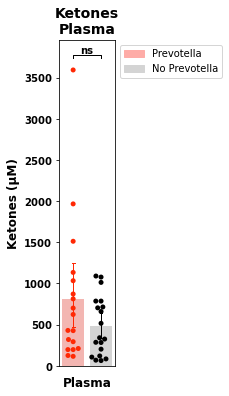

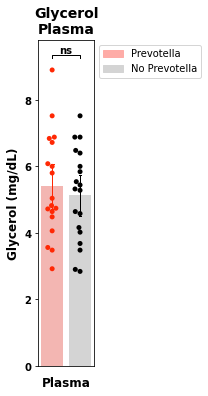

In [115]:
#Ketone and glycerol single analyte 
data_path = "{0}/20220714_plasma_KETGLYC.csv".format(csv_dir)
data_df = pd.read_csv(data_path,header=0)
data_df.rename(columns={"KET":"Ketones"},inplace=True)
# display(data_df)

bar_figures_dir = "figures/analyte_bar/plasma"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

single_analyte_stats(data_df,analyte_col="Ketones",tissue="plasma",sampleID_col="Mouse_ID")
single_analyte_stats(data_df,analyte_col="Glycerol",tissue="plasma",sampleID_col="Mouse_ID")

single_analyte_barplot(data_df,analyte="Ketones",tissue="plasma",sampleID_col="Mouse_ID",sigstr_fmt="std")
single_analyte_barplot(data_df,analyte="Glycerol",tissue="plasma",sampleID_col="Mouse_ID",sigstr_fmt="std",units="mg/dL")

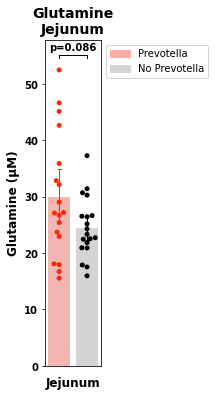

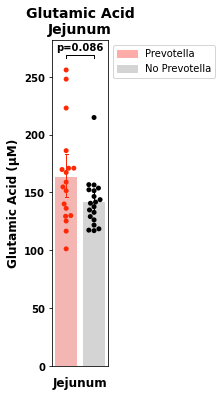

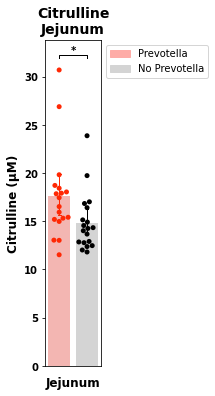

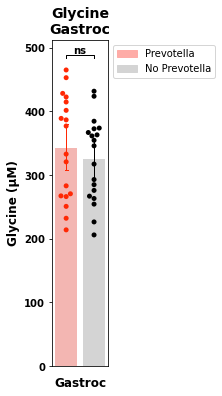

In [117]:
#Load full tissue AC and AA datasets 
plasma_AC_df = pd.read_csv("{0}/plasma_AC.csv".format(csv_dir),header=3)
tissue_amine_df = pd.read_csv("{0}/tissue_amine.csv".format(csv_dir),header=3)
tissue_AC_df = pd.read_csv("{0}/tissue_AC.csv".format(csv_dir),header=3)

tissue_amine_df.dropna(how="all",inplace=True)
tissue_amine_df.dropna(how="all",axis=1,inplace=True)
plasma_AC_df.dropna(how="all",inplace=True)

tissue_amine_df.rename(columns=lambda x: x.strip(),inplace=True)
tissue_AC_df.rename(columns=lambda x: x.strip(),inplace=True)
plasma_AC_df.rename(columns=lambda x: x.strip(),inplace=True)

#AC and amine columns 
amine_columns = tissue_amine_df.columns[4:]
AC_columns = tissue_AC_df.columns[4:]
plasma_AC_columns = plasma_AC_df.columns[7:]

#Convert to nM for consistency with HWDC original experiment data 
tissue_AC_df.loc[:,AC_columns] = tissue_AC_df.loc[:,AC_columns]*1000
tissue_amine_df.loc[:,amine_columns] = tissue_amine_df.loc[:,amine_columns]
plasma_AC_df.loc[:,plasma_AC_columns] = plasma_AC_df.loc[:,plasma_AC_columns]*1000

show_tables = False
if show_tables:
    with pd.option_context('display.max_rows',None):
        display(plasma_AC_df)
        display(tissue_amine_df)
        display(tissue_AC_df)
#Useful analyte lists 
nonOH_DC = AC_columns[~AC_columns.str.contains("OH|DC")]
FA_derived_ACs = nonOH_DC[~nonOH_DC.str.contains(":[4,5]")]
FA_derived_ACs = FA_derived_ACs.drop("C2")
SFA_ACs = FA_derived_ACs[~FA_derived_ACs.str.contains(":")].tolist()
UFA_ACs = FA_derived_ACs[FA_derived_ACs.str.contains(":")].tolist()    
soybean_ACs = ["C16","C18","C18:1","C18:2","C18:3"]    
    
analytes = soybean_ACs
tissues = ["Jejunum"]
bar_figures_dir = "figures/analyte_bar/tissue_og_replication"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

single_analyte_barplot(tissue_amine_df,"Glutamine",tissue="Jejunum",sigstr_fmt="pval")
single_analyte_barplot(tissue_amine_df,"Glutamic Acid",tissue="Jejunum",sigstr_fmt="pval")
single_analyte_barplot(tissue_amine_df,"Citrulline",tissue="Jejunum",sigstr_fmt="std")
single_analyte_barplot(tissue_amine_df,"Glycine",tissue="Gastroc",sigstr_fmt="std")


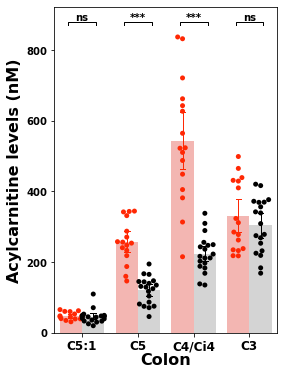

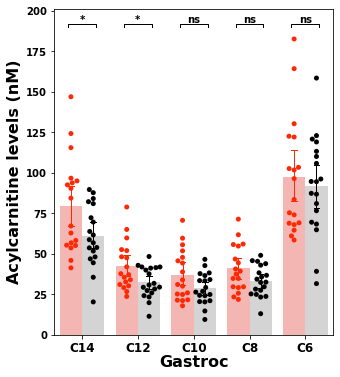

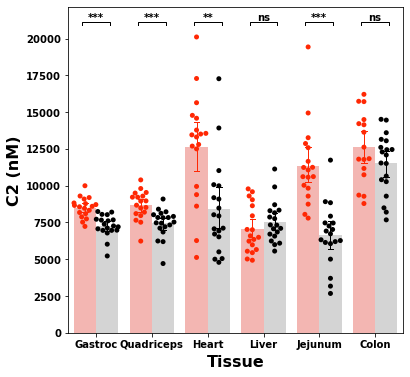

In [134]:
bar_figures_dir = "figures/analyte_bar/tissue_og_replication"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
#Colon BCAA derived ACs
analytes = ["C5:1","C5","C4/Ci4","C3"]
tissues = ["Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=False)

#Gastroc MCFA derived ACs
analytes = ["C14","C12","C10","C8","C6"]
tissues = ["Gastroc"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=False)

# #C2
analytes = ["C2"]
tissues = ["Gastroc","Quadriceps","Heart","Liver","Jejunum","Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes,tissues,units="nM",sigstr_fmt="std",legend=False)
# multiple_analyte_barplot(tissue_AC_df,analytes=analytes,tissues=tissues,A_group_re=r'AF|AM',group_col="SampleID",
#                            ax=None,units="nM",sig_strs=tissue_AC_ss.loc[analytes,tissues],legend=False)
# single_analyte_barplot(plasma_AC_df,"C2",tissue="Plasma",units="nM",sig_str=tissue_AC_ss.loc["C2","Plasma"])

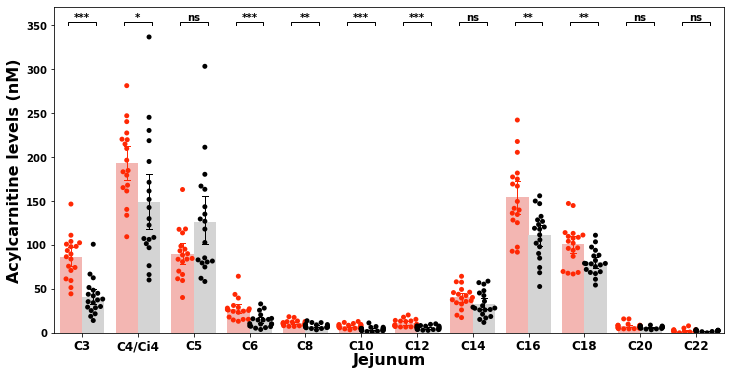

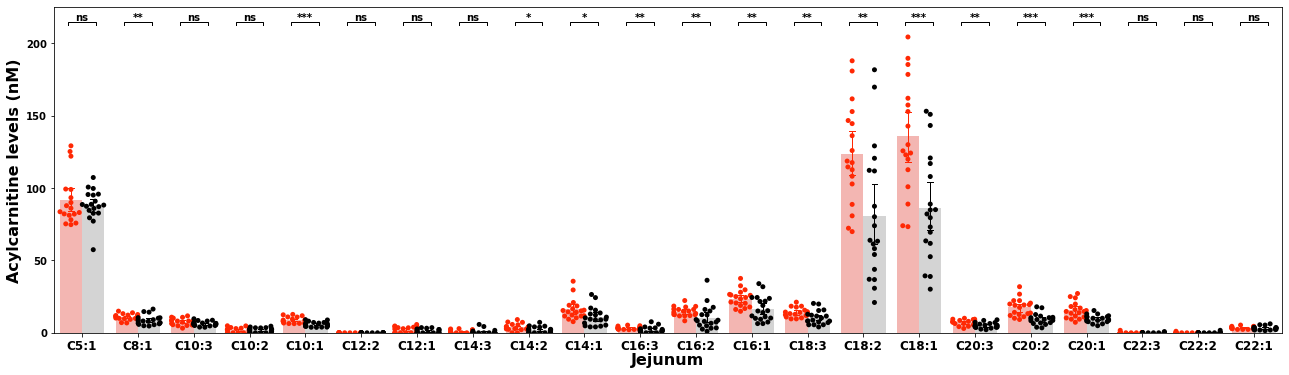

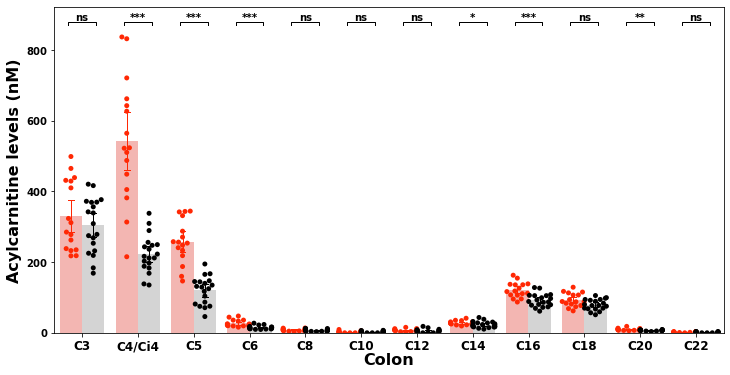

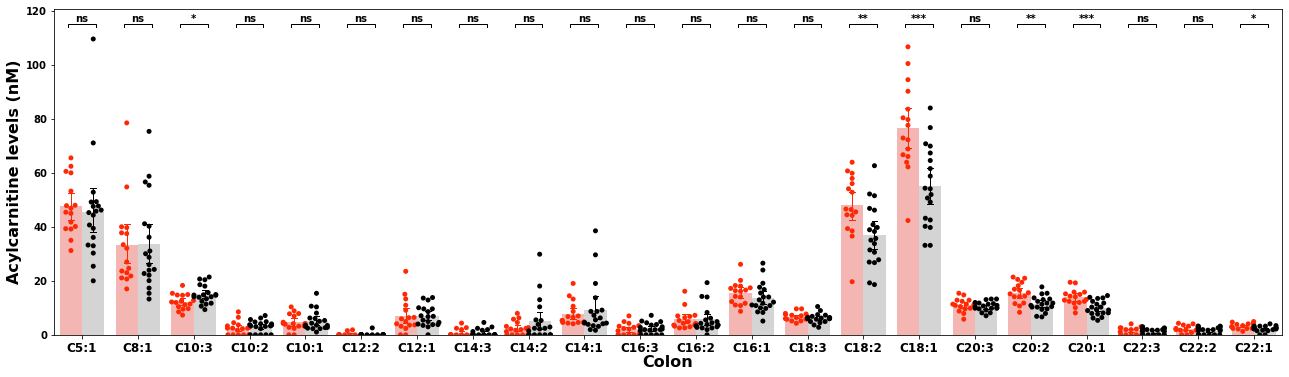

In [143]:
bar_figures_dir = "figures/analyte_bar/AC_panel/intestine"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)

#FA derived ACs - intestine results
nonOH_DC = AC_columns[~AC_columns.str.contains("OH|DC")]
FA_derived_ACs = nonOH_DC[~nonOH_DC.str.contains(":[4,5]")]
FA_derived_ACs = FA_derived_ACs.drop("C2")

SFA_ACs = FA_derived_ACs[~FA_derived_ACs.str.contains(":")].tolist()
UFA_ACs = FA_derived_ACs[FA_derived_ACs.str.contains(":")].tolist()

#SFA ACs, UFA ACs Jejunum
tissues=["Jejunum"]
multiple_analyte_barplot(tissue_AC_df,analytes=SFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
multiple_analyte_barplot(tissue_AC_df,analytes=UFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
#SFA ACs, UFA ACs Colon
tissues=["Colon"]
multiple_analyte_barplot(tissue_AC_df,analytes=SFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
multiple_analyte_barplot(tissue_AC_df,analytes=UFA_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)



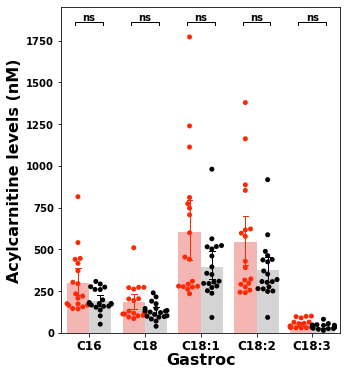

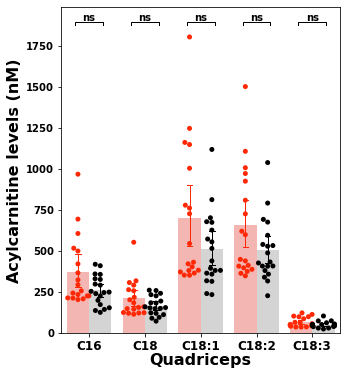

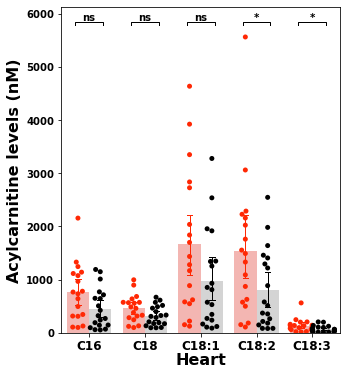

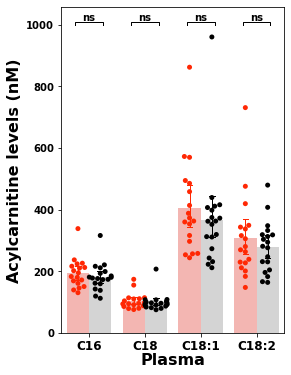

In [142]:
bar_figures_dir = "figures/analyte_bar/AC_panel/muscle"
if not os.path.exists(bar_figures_dir):
    os.makedirs(bar_figures_dir)
soybean_ACs = ["C16","C18","C18:1","C18:2","C18:3"]
soybean_4ACs = ["C16","C18","C18:1","C18:2"]
tissues=["Gastroc"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
tissues=["Quadriceps"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
tissues=["Heart"]
multiple_analyte_barplot(tissue_AC_df,analytes=soybean_ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
tissues=["Plasma"]
multiple_analyte_barplot(plasma_AC_df,analytes=soybean_4ACs,tissues=tissues,sigstr_fmt="std",units="nM",legend=False)
